In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
caffe_root = '/opt/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe import layers as L, params as P

In [3]:
import os
sys.path.insert(0, "src")
from netUtils import GetNetParams, getDataset, storeDataset, WriteNets, CountStageBatches
from netUtils import GetData, addSnapshotFileName, readFromFile, split
from Utils import UniqueRows, sample2gtCameraVector
from TestCameraNets import testDetectionClassification

# Detection classification
Classify into true positive and false positive detections

## Construct dataset

In [4]:
from sklearn.utils import shuffle
import numpy.random as npr
import numpy as np
import h5py

datasetPath = "data/dataset/"

def constructFilterElements(in_fileArray, in_dataFactor):
    sampleArray = [readFromFile(x)[0] for x in in_fileArray]
        
    nPoints = 0
    for sample in sampleArray:
        nPoints += sample["head"].shape[0]
    if (nPoints == 0):
        return None, None
    
    headArray   = None
    cameraArray = None
    # true positives
    iStart = 0
    iStop = 0
    for iSample, sample in enumerate(sampleArray):
        locationArray = sample["location"]
        nLocations = locationArray.shape[0]
        assert(nLocations >= 200)
        iStop = iStart + nLocations
        
        curHeadArray = sample["head"][:, :3]
        curCamera    = sample2gtCameraVector(sample)
        curCamera = curCamera * np.ones((nLocations, curCamera.shape[1]), dtype = np.float32)
        
        if (headArray is None):
            headArray = np.empty((nPoints, curHeadArray.shape[1]), dtype = np.float32)
            cameraArray = np.empty((nPoints, curCamera.shape[1]), dtype = np.float32)
        
        headArray[iStart : iStop]   = curHeadArray
        cameraArray[iStart : iStop] = curCamera
        
        iStart = iStop
    assert(iStop == nPoints)
    
    tpX = np.hstack((headArray, cameraArray))
    tpY = np.ones((tpX.shape[0], 1), dtype = np.int32)
    
    # false positives
    
    fpCameraArray = cameraArray[npr.permutation(cameraArray.shape[0])]    
    fpX = np.hstack((headArray, fpCameraArray))
    iSize = headArray.shape[1] - 1
    minSize = fpX[:, iSize].min()
    maxSize = fpX[:, iSize].max()
    
    dif = maxSize - minSize
    minSize = minSize - 0.5 * dif
    maxSize = maxSize + 0.5 * dif

    randFactor = in_dataFactor
    nPoints = headArray.shape[0]
    idxArray = npr.permutation(nPoints)
    nPoints = int(randFactor * nPoints)
    idxArray = idxArray[:nPoints]
    
    fpX[idxArray, iSize] = npr.rand(nPoints) * (maxSize - minSize) + minSize
    fpY = np.zeros((tpX.shape[0], 1), dtype = np.int32)
    
    X = np.vstack((tpX, fpX))
    Y = np.vstack((tpY, fpY))
    return X, Y.astype(int)

import pickle
datasetName = "filter"
dataFactor = 0.1
testName = str(dataFactor)
filterParams = GetNetParams(datasetName, testName, {"train": 4 * 8192, "test": 4 * 8192})
datasetFiles = filterParams["dataset"]

if not (os.path.isfile(datasetFiles["train"]) and os.path.isfile(datasetFiles["test"])
        and os.path.isfile(datasetFiles["scaler"])):
    # construct dataset
    fileNameArray = GetData(datasetPath, False)
    baseDir = os.path.join(os.path.dirname(filterParams["dataset"]["train"]), datasetName)
    if not (os.path.isdir(baseDir)):
        os.mkdir(baseDir)
    fileArray = []
    dsFileNameArray = {}
    X = {}
    Y = {}
    dsFileNameArray["train"], dsFileNameArray["test"] = split(fileNameArray, 0.2)
    for ds in ["train", "test"]:
        X[ds], Y[ds] = constructFilterElements(dsFileNameArray[ds], dataFactor)
    
    filterScaler = None
    try:
        with open(datasetFiles["scaler"], "rb") as f:
            filterScaler = pickle.load(f)
    except:
        allX = np.vstack([d[1] for d in X.iteritems()])
        filterScaler = {"input": constructPersonScaler(allX)}
        with open(datasetFiles["scaler"], "wb") as f:
            pickle.dump(filterScaler, f)
    for ds in ["train", "test"]:
        X[ds] = filterScaler["input"].transform(X[ds])
        X[ds], Y[ds] = shuffle(X[ds], Y[ds])
        storeDataset(filterParams["dataset"][ds], X[ds], Y[ds])

In [5]:
for ds in ["train", "test"]:
    tmp = getDataset(filterParams["dataset"][ds], ["data"])
    print("{:d} unique {:s} scenes".format(UniqueRows(tmp["data"][:, 3:]).shape[0], ds))

80 unique train scenes
20 unique test scenes


In [6]:
def filterNet(in_data, in_batchSize):
    n = caffe.NetSpec()

    n.data, n.label = L.HDF5Data(batch_size=in_batchSize, source=in_data, ntop = 2)

    n.fc1   = L.InnerProduct(n.data, num_output=20, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)

    n.fc2   = L.InnerProduct(n.relu1, num_output=20, weight_filler=dict(type='xavier'))
    n.relu2 = L.ReLU(n.fc2, in_place=True)

    #'''
    n.fc3   = L.InnerProduct(n.relu2, num_output=20, weight_filler=dict(type='xavier'))
    n.relu3 = L.ReLU(n.fc3, in_place=True)    

    n.fc4   = L.InnerProduct(n.relu3, num_output=20, weight_filler=dict(type='xavier'))
    n.relu4 = L.ReLU(n.fc4, in_place=True)    

    n.fc5   = L.InnerProduct(n.relu4, num_output=20, weight_filler=dict(type='xavier'))
    n.relu5 = L.ReLU(n.fc5, in_place=True) 
    
    n.score = L.InnerProduct(n.relu5, num_output=2, weight_filler=dict(type='xavier'))
    
    n.loss  = L.SoftmaxWithLoss(n.score, n.label)
    return n.to_proto()

WriteNets(filterParams, filterNet)

## Create solver

In [7]:
import h5py
import numpy as np
caffe.set_mode_gpu()
niter = 100 # number of iterations to train

numTestBatches = CountStageBatches(filterParams, "test")
print(str(numTestBatches) + " test batches")

# Reset style_solver as before.
solverFileName = filterParams["solver"]
snapshotPrefix = filterParams["snapshotPrefix"]
stepSize = 100

isLearned = os.path.isfile(addSnapshotFileName(filterParams, niter * stepSize))
print("Model is learned: [" + str(isLearned) + "]")

if not isLearned:
    solver(filterParams["net"]["train"], filterParams["net"]["test"], 0.1, numTestBatches,
           solverFileName, snapshotPrefix, in_stepSize = 1500, in_gamma = 0.95)
    my_solver = caffe.get_solver(solverFileName)

1 test batches
Model is learned: [True]


## Learn model

In [8]:
if not isLearned:
    print 'Running solvers for %d iterations...' % niter
    loss, test_loss = run_solvers(niter, my_solver, numTestBatches)
    print 'Done.'

In [9]:
if not isLearned:
    trainX = np.arange(loss["camera"].size)
    testX = np.arange(test_loss["camera"].size) * 10
    plt.plot(trainX, loss["camera"], testX, test_loss["camera"])
    plt.legend(["person train", "person test"])
    plt.show()

## Evaluate on synthetic data

Net testing: 100%|██████████| 1/1 [00:00<00:00, 170.35it/s]


Train accuracy = 0.9003
Test accuracy = 0.895205


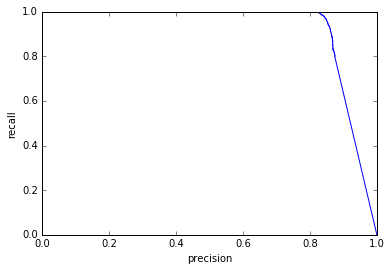

In [14]:
from sklearn.metrics import precision_recall_curve
import pandas as pd

#net = caffe.Net(filterParams["net"]["test"], filterParams["net"]["snapshot"], caffe.TEST)
for ds in ["train", "test"]:
    dsData = getDataset(filterParams["dataset"][ds], ["data", "label"])
    scaler = readFromFile(filterParams["dataset"]["scaler"])
    dsData["data"] = scaler["input"].inverse_transform(dsData["data"])
    score = testDetectionClassification(filterParams, dsData["data"][:, :3],
                                        dsData["data"][:, 3:])
    gtPos = (dsData["label"].ravel() == 1)
    prec, rec, thArray = precision_recall_curve(gtPos, score)
    if (ds == "test"):
        with open("/home/e_sha/train_pr.csv", "w") as f:
            pd.DataFrame({"prec": prec, "rec": rec}).to_csv(f, header = False, sep = ";")
        plt.plot(prec, rec)
    acc = ((score > 0.5) == (dsData["label"].ravel() == 1)).mean()
    print("{:s} accuracy = {:g}".format(ds.capitalize(), acc))
plt.xlabel("precision")
plt.ylabel("recall")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.savefig("/home/e_sha/train_pr.pdf")
plt.show()

In [15]:
dsData = GetData(datasetPath)

Dataset reading: 100%|██████████| 100/100 [00:00<00:00, 1424.81it/s]


In [16]:
testData = [np.hstack((x["head"][:, :3],
                      x["target"].reshape(1, -1) + np.zeros((x["head"].shape[0], 1))))
           for x in dsData]
testData = np.vstack(testData)
score = testDetectionClassification(filterParams, testData[:, :3], testData[:, 3:])
recall = (score > 0.5).mean()
print("Recall = {:g}".format(recall))

Net testing: 100%|██████████| 1/1 [00:00<00:00, 134.33it/s]

Recall = 0.971277


## Evaluate on TownCentre

### Classification of true positive detections

Net testing: 100%|██████████| 1/1 [00:00<00:00, 183.05it/s]


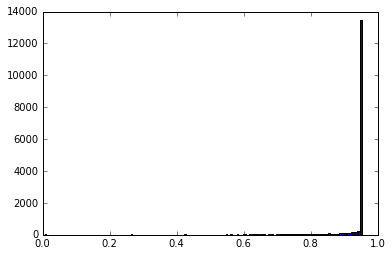

drawing: 100%|██████████| 5/5 [00:00<00:00, 28.24it/s]


In [17]:
import cv2
from scipy.misc import imread, imsave
from tqdm import tqdm

def visualizeBboxes(bboxArray, nFrameDetections, scoreArray, inputTemplate, outputTemplate):
    outDir = os.path.dirname(outputTemplate)
    if not os.path.isdir(outDir):
        os.makedirs(outDir)

    tmpData = bboxArray.copy()
    tmpData[:, 2:] += tmpData[:, :2] - 1
    bboxArray = bboxArray.astype(int)

    pShift = 0
    nFrames = nFrameDetections.size
    for iFrame in tqdm(range(nFrames), "drawing"):
        img = imread(inputTemplate.format(iFrame))
        
        for idx in range(nFrameDetections[iFrame]):
            iPoint = pShift + idx
            if (res[iPoint] >= 0.5):
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(img, tuple(bboxArray[iPoint, :2]), tuple(bboxArray[iPoint, 2:]),
                         color, 2)
        pShift += nFrameDetections[iFrame]
        imsave(outputTemplate.format(iFrame), img)
        
fileName = "data/TownCentreTPHeadArray.p"
realData, tcnFrameDet = readFromFile(fileName)
camData = np.array([[1.92574481e+00, -1.79952645e-02, 7.96049282e+00, 2.69635889e+03]])
res = testDetectionClassification(filterParams, realData, camData)

plt.hist(res, 200)
plt.show()

visualizeBboxes(realData, tcnFrameDet[:5], res, "data/TownCentre/frame{:04d}.jpg",
                "visualization/clear/frame{:04d}.jpg")

### Classification of all detections

Net testing: 100%|██████████| 6/6 [00:00<00:00, 231.90it/s]


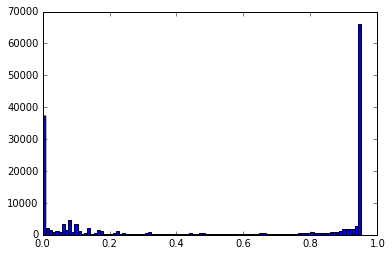

drawing: 100%|██████████| 10/10 [00:00<00:00, 29.65it/s]


In [18]:
fileName = "data/TownCentreHeads.p"
clutteredData = readFromFile(fileName)
clutteredHeads = np.vstack(tuple([x["headArray"] for x in clutteredData]))

res = testDetectionClassification(filterParams, clutteredHeads[:, :3], camData)

plt.hist(res, 100)
plt.show()

nFrameDetections = np.array([x["headArray"].shape[0] for x in clutteredData[:10]])
visualizeBboxes(clutteredHeads[:, :4], nFrameDetections, res, "data/TownCentre/frame{:04d}.jpg",
                "visualization/cluttered/frame{:04d}.jpg")

## Processing masks for TownCentre scene

Net testing: 100%|██████████| 2025/2025 [00:06<00:00, 291.59it/s]


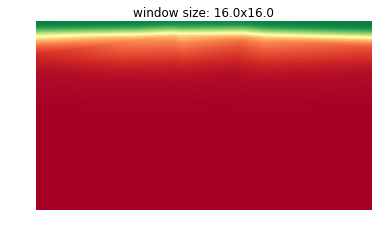

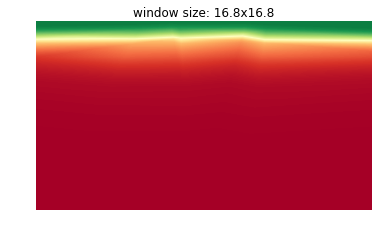

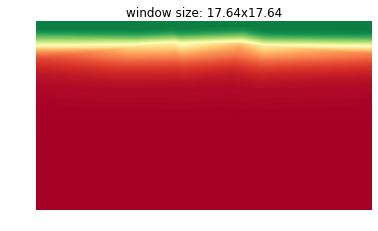

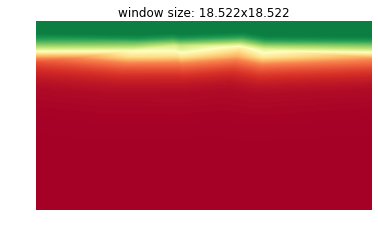

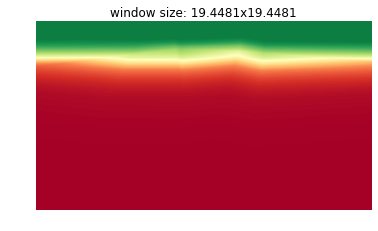

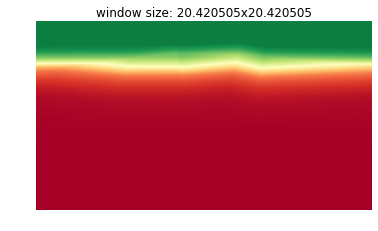

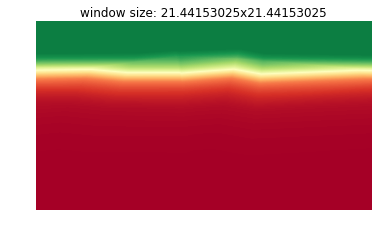

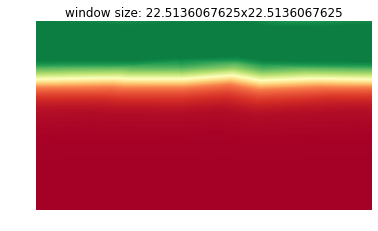

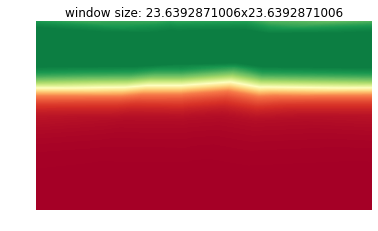

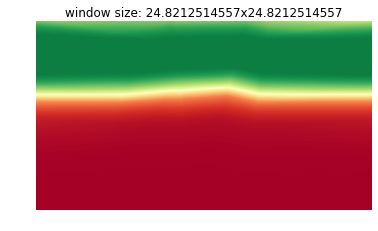

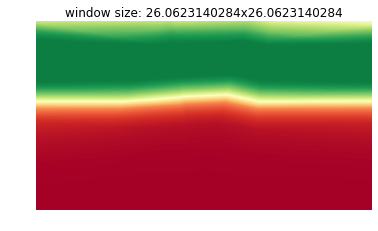

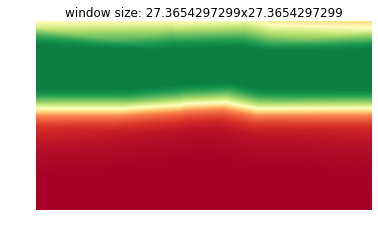

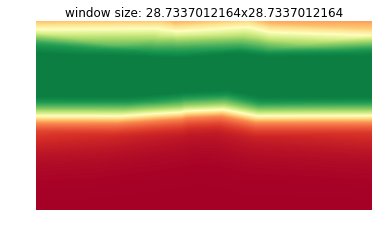

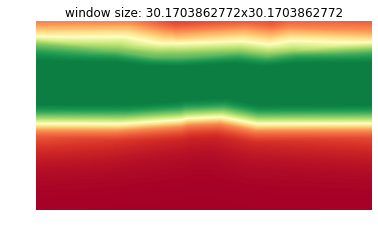

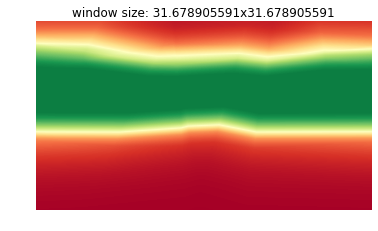

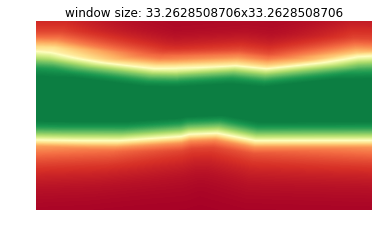

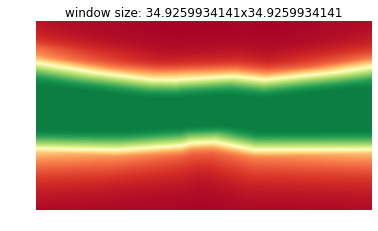

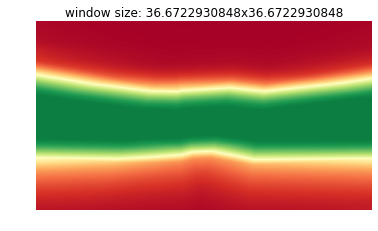

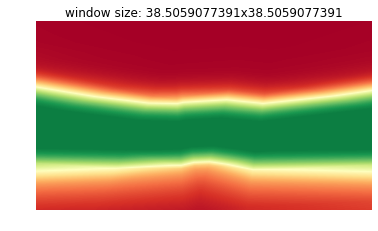

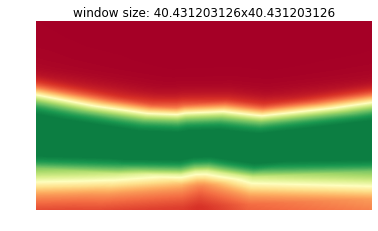

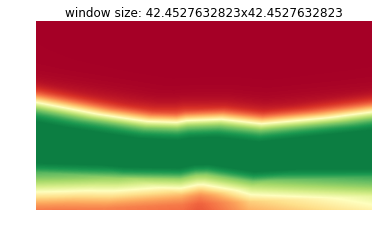

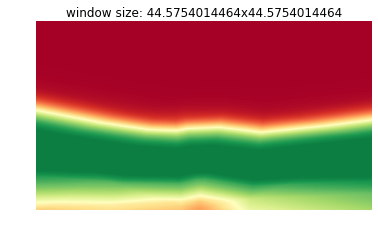

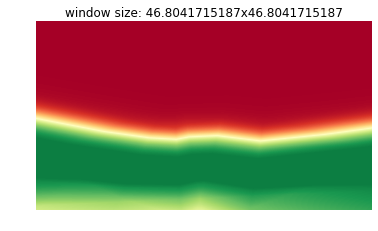

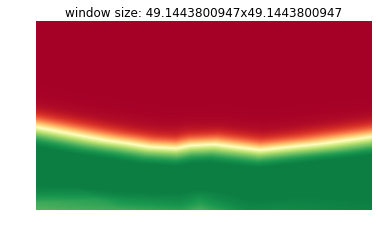

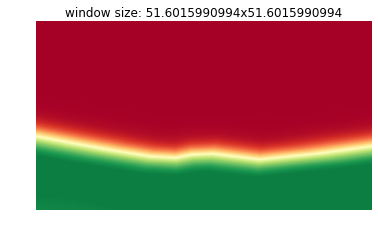

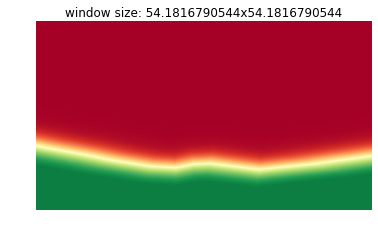

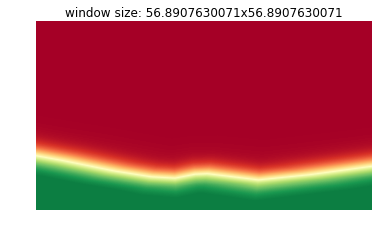

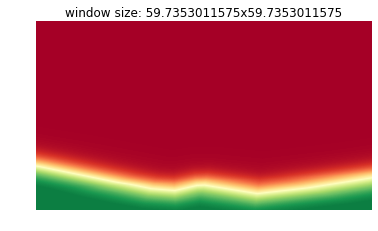

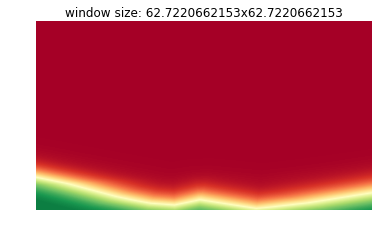

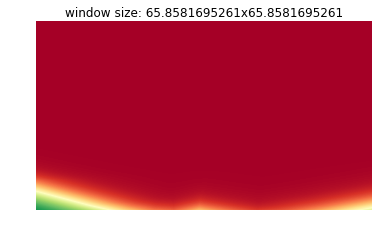

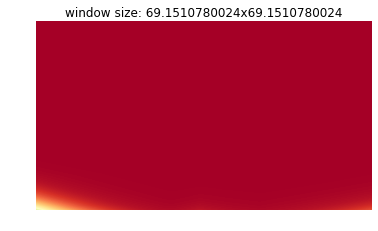

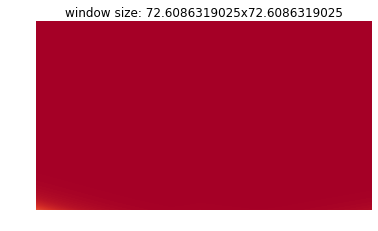

In [19]:
def ProbMesh(in_imSize, in_camData, in_minSize, in_maxSize, in_factor, in_netParams):

    xArray, yArray = np.meshgrid(range(in_imSize[0]), range(in_imSize[1]))
    xArray = xArray.reshape(-1, 1)
    yArray = yArray.reshape(-1, 1)
    meshArray = np.hstack((xArray, yArray))

    nScales = np.log(float(in_maxSize) / in_minSize) / np.log(in_factor)
    elArray = np.empty((meshArray.shape[0] * int(nScales), meshArray.shape[1] + 1))
    for iScale in range(int(nScales)):
        curSize = in_minSize * np.power(in_factor, iScale)
        tl = meshArray - (curSize - 1) / 2
        curElArray = np.hstack((tl, curSize * np.ones((tl.shape[0], 1))))
        iStart = iScale * tl.shape[0]
        iStop = iStart + tl.shape[0]
        elArray[iStart : iStop, :] = curElArray

    nPoints = elArray.shape[0]
    res = testDetectionClassification(in_netParams, elArray, in_camData)
    resSize = np.hstack((-1, imSize[[1, 0]].astype(int)))
    return res.reshape(resSize)

import matplotlib.cm as cm
def Prob2img(in_probArray):
    return cm.RdYlGn(in_probArray.ravel()).reshape(np.hstack((in_probArray.shape, -1)))
    
minSize = 16
factor = 1.05
maxSize = 80
scaler = readFromFile(filterParams["dataset"]["scaler"])
imSize = np.array([1920, 1080])
probArray = ProbMesh(imSize, camData[0, :4], minSize, maxSize, factor, filterParams)
nScales = probArray.shape[0]

import matplotlib.cm as cm
colorArray = Prob2img(probArray)

for iScale in range(nScales):
    curSize = minSize * np.power(factor, iScale)
    plt.imshow(colorArray[iScale])
    plt.title("window size: " + str(curSize) + "x" + str(curSize))
    plt.axis('off')
    plt.savefig("visualization/mask{:d}.png".format(iScale))
    plt.show()

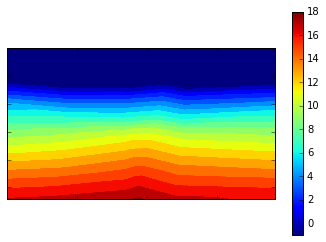

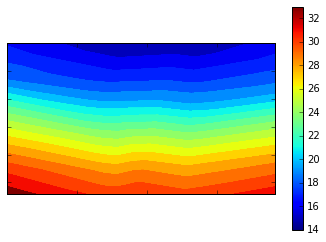

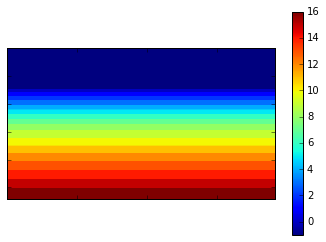

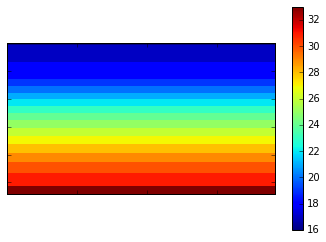

In [20]:
th = .05
tmpMask = probArray > th
state = np.zeros(tmpMask.shape[1:], dtype = np.int32)
start = -np.ones(tmpMask.shape[1:], dtype = np.int32)
stop = int(nScales + 1) * np.ones(tmpMask.shape[1:], dtype = np.int32)

def drawMap(in_map, in_outFileName = None):
    plt.imshow(in_map)
    plt.tick_params(
        axis='both',       # changes apply to the x-axis
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')   # labels along the bottom edge are off
    cb = plt.colorbar()
    if not in_outFileName is None:
        plt.savefig("visualization/bottom.pdf")
    plt.show()

for iScale in range(int(nScales)):
    curMask = np.logical_and(tmpMask[iScale, :, :], state == 0)
    state[curMask] = 1
    start[curMask] = iScale - 1
    curMask = np.logical_and(np.logical_not(tmpMask[iScale, :, :]), state == 1)
    state[curMask] = 2
    stop[curMask] = iScale
    
drawMap(start, "visualization/bottom.pdf")
drawMap(stop, "visualization/top.pdf")

drawMap(start.min(axis = 1).reshape(-1, 1) + np.zeros((1, start.shape[1])), 
        "visualization/bottom_detector.pdf")
drawMap(stop.max(axis = 1).reshape(-1, 1) + np.zeros((1, stop.shape[1])),
        "visualization/top_detector.pdf")

## Precision-recall curves for detector with a filter

Threshold choice:   0%|          | 5/1001 [00:00<00:23, 43.14it/s]

Basic AUC value: 0.548783
Basic precision: 0.484
Basic recall: 0.66


Threshold choice: 100%|██████████| 1001/1001 [00:17<00:00, 57.50it/s]


Modified threshold: 0.32
Best AUC value: 0.725415
Modified precision: 0.761
Modified recall: 0.598


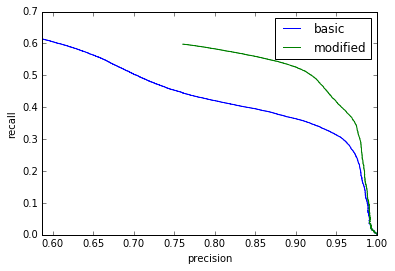

In [21]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from IoU import IoU

def UpdateScore(score, nLost, mask = None):
    newScore = score.copy()
    if (not mask is None):
        newScore[mask] = -1
    return np.hstack((newScore, -np.ones(nLost)))

def chooseBestThreshold(detections, filterParams, camData, score, nLost, labels):
    headArray = np.vstack([x["headArray"][:, :3] for x in detections])
    res = testDetectionClassification(filterParams, headArray[:, :3], camData)
    aArray = []
    valArray = []
    for a in tqdm(np.linspace(0, 1, 1001), "Threshold choice"):
        aArray.append(a)
        valArray.append(roc_auc_score(labels, UpdateScore(score, nLost, res < a)))
    
    idx = np.argmax(valArray)
    return aArray[idx], valArray[idx], res

def readGt(fileName):
    gt = pd.read_csv(gtFileName, header = None)
    gt = np.array(gt[[1, 4, 5, 6, 7]])
    frameArray = np.unique(gt[:, 0])
    gtData = [gt[gt[:, 0] == iFrame, 1:] for iFrame in frameArray]
    return [np.hstack((x[:, :2], x[:, 2:] - x[:, :2])) for x in gtData], frameArray

def detectionsToLabels(detections, gt, frameArray, threshold):
    labels = [None for x in frameArray]
    nLost = 0
    for iFrame in tqdm(frameArray.astype(int), "frames filtering"):
        assert(detections[iFrame]["frame"] == iFrame)
        mes = IoU(detections[iFrame]["headArray"], gt[iFrame])
        labels[iFrame] = mes.max(1) > th
        nLost += (mes.max(0) < th).sum()
    
    labels = np.hstack(labels)
    labels = np.hstack((labels, np.ones(nLost)))
    return labels, nLost

gtFileName = "data/TownCentre-groundtruth.top"
gtData, frameArray = readGt(gtFileName)

th = 0.25

labels, nLost = detectionsToLabels(clutteredData[:4501], gtData, frameArray, th)
score = np.hstack([x["headArray"][:, -1] for x in clutteredData[:4501]])

prec, rec, _ = precision_recall_curve(labels, UpdateScore(score, nLost))
plt.plot(prec[1:], rec[1:])

print("Basic AUC value: {:g}".format(roc_auc_score(labels, UpdateScore(score, nLost))))
print("Basic precision: {:.3g}\nBasic recall: {:.3g}".format(prec[1], rec[1]))

chosenTh, aucVal, res = chooseBestThreshold(clutteredData[:4501], filterParams,
                                            camData, score, nLost, labels)
print("Modified threshold: {:g}\nBest AUC value: {:g}".format(chosenTh, aucVal))

prec, rec, _ = precision_recall_curve(labels, UpdateScore(score, nLost, res < chosenTh))
print("Modified precision: {:.3g}\nModified recall: {:.3g}".format(prec[1], rec[1]))

plt.plot(prec[1:], rec[1:])
plt.legend(["basic", "modified"])
plt.xlabel("precision")
plt.ylabel("recall")
plt.xlim([np.min(prec), 1])
plt.savefig("visualization/precision_recall.pdf")
plt.show()